Task : Coronavirus tweets NLP - Text Classification <br>
URL : https://www.kaggle.com/datatattle/covid-19-nlp-text-classification <br>
Author : Siddarthan <br>
Description : This notebook contains the pipeline to preprocess covid NLP data, create and train LSTM based neural network to classify the data. <br>
Created on : 15-11-2021 <br>
Updated on : 16-11-2021 <br>


In [1]:
# Import required packages

import pandas as pd
import numpy as np
import torch
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from time import time
from datetime import timedelta

from torch import nn

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# Path to csv files

train_file = "../input/covid-19-nlp-text-classification/Corona_NLP_train.csv"
test_file = "../input/covid-19-nlp-text-classification/Corona_NLP_test.csv"

In [3]:
# Select device gpu/cpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Exploration


In [4]:
# Read the csv files
train_data = pd.read_csv(train_file, encoding='latin1')
test_data = pd.read_csv(test_file, encoding='latin1')

In [5]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


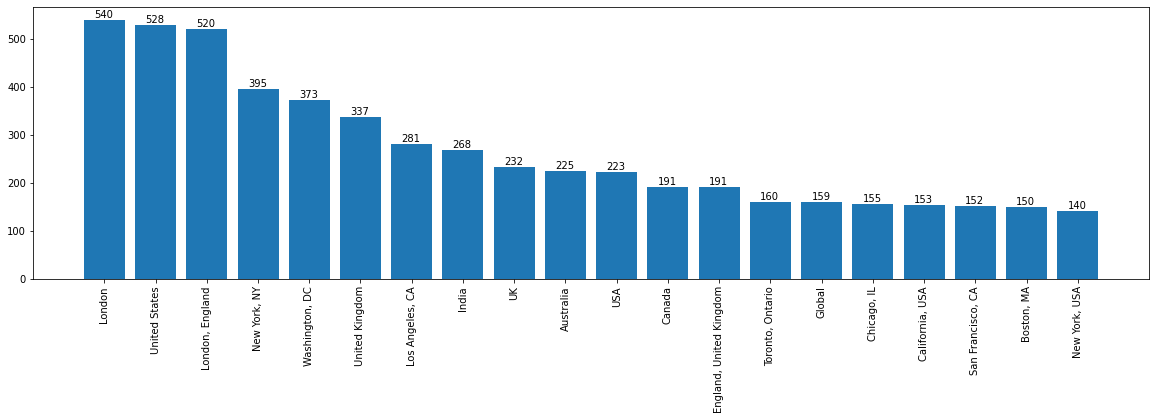

In [7]:
# Top locations of the tweets
location = train_data['Location'].value_counts().nlargest(20)
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(location.index, location.values)
plt.xticks(location.index, rotation='vertical')
for idx, val in enumerate(location):
    plt.text(idx-0.2, val+5, str(val))
plt.show()

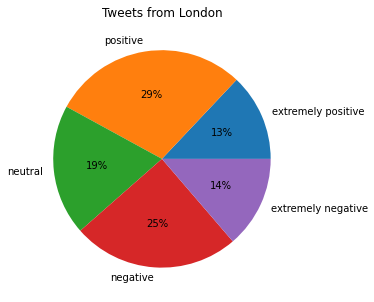

In [8]:
# Tweets originated from London (Top location)
extreme_positive_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Extremely Positive")])
positive_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Positive")])
neutral_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Neutral")])
negative_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Negative")])
extreme_negative_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Extremely Negative")])

labels = ["extremely positive", "positive", "neutral", "negative", "extremely negative"]
plt.pie([extreme_positive_tweets, positive_tweets, neutral_tweets, negative_tweets, extreme_negative_tweets],
        labels=labels, autopct='%1.0f%%')
plt.title("Tweets from London")
plt.show()


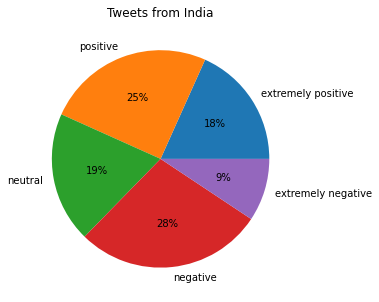

In [9]:
# Tweets originated from India
extreme_positive_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Extremely Positive")])
positive_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Positive")])
neutral_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Neutral")])
negative_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Negative")])
extreme_negative_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Extremely Negative")])

labels = ["extremely positive", "positive", "neutral", "negative", "extremely negative"]
plt.pie([extreme_positive_tweets, positive_tweets, neutral_tweets, negative_tweets, extreme_negative_tweets],
        labels=labels, autopct='%1.0f%%')
plt.title("Tweets from India")
plt.show()

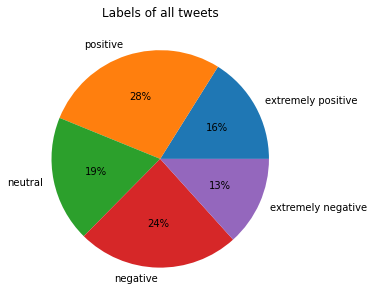

In [10]:
# Tweets originated from all locations
extreme_positive_tweets = len(train_data[train_data["Sentiment"] == "Extremely Positive"])
positive_tweets = len(train_data[train_data["Sentiment"] == "Positive"])
neutral_tweets = len(train_data[train_data["Sentiment"] == "Neutral"])
negative_tweets = len(train_data[train_data["Sentiment"] == "Negative"])
extreme_negative_tweets = len(train_data[train_data["Sentiment"] == "Extremely Negative"])

labels = ["extremely positive", "positive", "neutral", "negative", "extremely negative"]
plt.pie([extreme_positive_tweets, positive_tweets, neutral_tweets, negative_tweets, extreme_negative_tweets],
        labels=labels, autopct='%1.0f%%')
plt.title("Labels of all tweets")
plt.show()

In [11]:
# Check for missing values in training data
train_data.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [12]:
# Check for missing values in test data
test_data.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [13]:
# Check for duplicate tweets
print("Total tweets", len(train_data["OriginalTweet"]))
print("Unique tweets", len(set(train_data["OriginalTweet"])))

Total tweets 41157
Unique tweets 41157


The following observations were obtained from data exploration

1. The data under the header 'OriginalTweet' can be used as input data.
2. The data under the header 'Sentiment' can be used as the labels to predict.
3. The other columns can be removed.
4. Missing values are present only in the 'Location' column which is removed.
5. No duplicate tweets are found.
6. Five sentiments are labelled namely neutral, positive, extremely positive, negative and extremely negative
7. Sentiments can be reduced to three <br>
   a. positive (positive + extremely positive) <br>
   b. negative (negative + extremely negative) <br>
   c. neutral <br>
   (Positive and extremely positive will have similar context hence may not be differentiated easily by the model and it is the same for negative and extremely negative)

# Data Cleaning and transformation

In [14]:
# Filter the required columns

train_data = train_data[["OriginalTweet", "Sentiment"]]
test_data = test_data[["OriginalTweet", "Sentiment"]]

## Sentiment label preparation

In [15]:
train_data["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [16]:
test_data["Sentiment"].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

#### Positive and Extremely positive can be combined to a same class. Negative and Extremely negative can be combined to a same class.
#### This is due to the following reasons
1. Number of samples in each class in less. Hence the model may not learn the features properly
2. The context of Positive and Extremely positive samples will be similar. Hence the model may not differentiate between them. (A more complex model with more number of samples will be required to differentiate properly)

In [17]:
# Dictionary of labels and their integer values
label_index = {
    "Positive" : 0,
    "Negative" : 1,
    "Neutral"  : 2,
    "Extremely Positive" : 0,
    "Extremely Negative" : 1
}

In [18]:
# Convert the training labels to tensor values
train_y = []
for label in train_data["Sentiment"]:
    train_y.append(torch.tensor([label_index[label]], dtype=torch.long, device=device))

In [19]:
# Convert the test labels to tensor values
test_y = []
for label in test_data["Sentiment"]:
    test_y.append(torch.tensor([label_index[label]], dtype=torch.long, device=device))

3
[0.76022387 0.89095986 1.77868534]


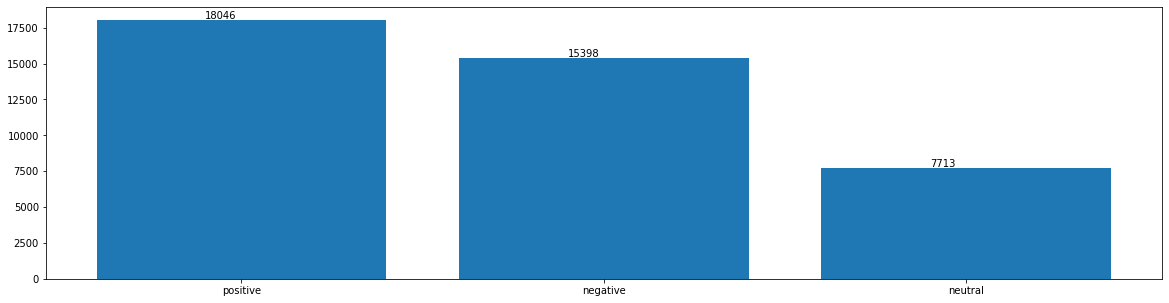

In [20]:
# Number of classes in the data
n_classes = len(set([item.item() for item in train_y]))
print(n_classes)

# Calculate class weights
labels = [label.item() for label in train_y]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
print(class_weights)

# Number of samples in each class
plt.bar(["positive", "negative", "neutral"],[labels.count(0), labels.count(1), labels.count(2)])
for idx, val in enumerate([labels.count(0), labels.count(1), labels.count(2)]):
    plt.text(idx-0.1, val+100, str(val))
plt.show()

#### From the data distribution, we can say that the model may learn the positive and negative samples properly since they are more in number compared to the neutral samples
#### Due to class imbalance, we can use class weights while calculating loss to given more importance to class with less number of samples


## Input data preparation

### Data Cleaning

Data cleaning techniques used
1. Removing urls since url does not contain any relevant information
2. Remove emoji and symbols
3. Expand words Ex. shouldn't -> should not - this will avoid duplicate embeddings (different embeddings for shouldn't and should not will affect the model performance)
4. Separate alphabets and numbers - it will split texts like 'abcd123' to 'abc', '123'
5. Truncate repeated single characters
6. Remove special characters - it will remove @ and # symbols that are commonly used in tweets
7. Convert to lower case

In [21]:
# Clean text

def remove_url(text):
    """
    Function to remove URL from the data
    """
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_emoji(text):
    """
    Function to remove the emojis from the data
    Ref : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    """

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def expand(text):
    """
    Function to expand the words commonly used in English
    """
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    """
    Function to separate alphabets and numbers that are found together
    in the text
    """
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)
    
def cont_rep_char(text):
    """
    Find repeating character
    """
    tchr = text.group(0)
    if len(tchr) > 1:
        return tchr[0:2]
    
def unique_char(rep, text):
    """
    Substitue repeating character with rep in text
    """
    sub = re.sub(r'(\w)\1+', rep, text)
    return sub

def special_char(text):
    """
    Remove special characters other than alphabets
    """
    return re.sub(r'[^a-zA-Z]',' ',text)

# Apply functions on the training data
train_data['OriginalTweet'] = [remove_url(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [remove_emoji(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [expand(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [seperate_alphanumeric(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [unique_char(cont_rep_char, data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [special_char(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [data.lower() for data in train_data['OriginalTweet']]

# Apply functions on the test data
test_data['OriginalTweet'] = [remove_url(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [remove_emoji(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [expand(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [seperate_alphanumeric(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [unique_char(cont_rep_char, data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [special_char(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [data.lower() for data in test_data['OriginalTweet']]


### Data Vectorization and Embedding

#### Main Objective of this step is to convert the sequence to tokens to sequence of numbers and obtain a dictionary of embedding vectors from glove

The following steps are carried out

1. Obtain the vectors from glove embeddings
2. Tokenize the input data and apply lemmatization
3. Create vocabulary of tokens and convert tokens to numbers
4. Based on the vocabulary and glove embeddings, obtain a pretrained weight matrix for embedding layer

We will obtain
1. Numerical input sequence
2. Weight matrix for embedding layer using glove

In [22]:
# Store the glove embeddings in a dictionary

embeddings_dict = {}
n_embeddings = 300
emb_file = open('../input/glove6b300dtxt/glove.6B.300d.txt', encoding='utf-8')
for line in tqdm(emb_file):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs
emb_file.close()

print('Found %s word vectors.' % len(embeddings_dict))

400000it [00:47, 8381.45it/s]

Found 400000 word vectors.


In [23]:
# Initialize the Lemmatizer
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# Create vocabulary from the training and test data
target_vocab = []

# Train data
for tweet in tqdm(train_data["OriginalTweet"]):
    tokens = word_tokenize(tweet)
    for token in tokens:
        token = lemmatizer.lemmatize(token)
        if token.lower() not in target_vocab:
            target_vocab.append(token.lower())

# Test data
for tweet in tqdm(test_data["OriginalTweet"]):
    tokens = word_tokenize(tweet)
    for token in tokens:
        token = lemmatizer.lemmatize(token)
        if token.lower() not in target_vocab:
            target_vocab.append(token.lower())
    
print(len(target_vocab))

100%|██████████| 3798/3798 [00:05<00:00, 638.09it/s]

50805


#### Glove embeddings are used for tokens that already exists. For non existing tokens, embeddings are randomly initialized.

In [25]:
# Create pretrained weight matrix for the embedding layer from glove embeddings

weight_matrix = torch.zeros((len(target_vocab), n_embeddings), device=device)
str_to_index = {}
for index, token in tqdm(enumerate(target_vocab), total=len(target_vocab)):
    str_to_index[token] = index

    # Existing embedding values
    try:
        weight_matrix[index] = torch.tensor(embeddings_dict[token], device=device)

    # Use a random value when embeddings are not found in glove
    except KeyError:
        weight_matrix[index] = torch.randn((n_embeddings,), device=device)
  

100%|██████████| 50805/50805 [00:01<00:00, 32443.35it/s]


#### Encode the tokens to numerical value based on vocabulary

In [26]:
# Encode the tokens tokens in training data using the created vocabulary
encoded_train_X = []
for tweet in tqdm(train_data["OriginalTweet"]):
    tokens = word_tokenize(tweet)
    data = []

    for token in tokens:

        # Lemmatize the token
        token = lemmatizer.lemmatize(token)

        # Get the index of the token from the vocabulary
        data.append(str_to_index[token.lower()])

    encoded_train_X.append(torch.tensor(data, dtype=torch.long, device=device))


100%|██████████| 41157/41157 [00:22<00:00, 1849.15it/s]


In [27]:
# Encode the tokens in test data using the created vocabulary
encoded_test_X = []
for tweet in tqdm(test_data["OriginalTweet"]):
    tokens = word_tokenize(tweet)
    data = []

    for token in tokens:

        # Lemmatize the token
        token = lemmatizer.lemmatize(token)

        # Get the index of the token from the vocabulary
        data.append(str_to_index[token.lower()])

    encoded_test_X.append(torch.tensor(data, dtype=torch.long, device=device))


100%|██████████| 3798/3798 [00:02<00:00, 1847.57it/s]


# Model creation


## Model defintion

#### The model contains an embedding layer, a Bidirectional LSTM layers followed by a couple of fully connected layers.
#### The weights of embedding layers are intialize using the glove embeddings.

#### Reason for choosing this network 
1. The data is less hence a less complex model need to be used (One LSTM layer)
2. Bidirectional LSTM is used since it gets the features along both forward and backward directions in the sequence
3. Dropout is used due to less training data. Dropout can avoid overfitting. 
4. Using a pretrained weight for embedding layer can reduce training time.

In [28]:
class LstmClassifier(nn.Module):
  """
  Covid tweet classifer using LSTM layers
  """
  def __init__(self, weight_matrix, n_class, hidden_size1=50, hidden_size2=50, 
               load_weight=False):
    """
    Intialize the embedding and LSTM layer and load the weights
    """
    super().__init__()
    n_embeddings, embedding_dim = weight_matrix.shape
    self.embedding = nn.Embedding(n_embeddings, embedding_dim)
    if load_weight:
      self.embedding.load_state_dict = weight_matrix
    self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size1, 
                         bidirectional=True)
    self.fc = nn.Linear(2*hidden_size1, hidden_size2)
    self.act = nn.ReLU()
    self.drop = nn.Dropout(0.2)
    self.out = nn.Linear(hidden_size2, n_class)

  def forward(self, data):
    """
    Pass the input through the model and return the output tensor
    """
    out = self.embedding(data)
    out, _ = self.lstm1(out.unsqueeze(0))
    out = torch.mean(out, dim=1)
    out = self.act(self.fc(out))
    out = self.drop(out)
    out = self.out(out)

    return out

In [29]:
# Intialize the model, loss function and optimizer

learning_rate = 0.001
n_epochs = 10
batch_size = 128
test_interval = 1

classifier_lstm = LstmClassifier(weight_matrix, n_class=n_classes, load_weight=True).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(classifier_lstm.parameters(), lr=learning_rate)

# Model Training

In [30]:
# Placeholders to store model progress
train_loss = []
train_accuracy = []
train_f1 = []
test_loss = []
test_accuracy = []
test_f1 = []

epoch_start_time = time()
for epoch in range(1, n_epochs+1):

  ##########
  # TRAINING
  ##########

  classifier_lstm.train()
  
  # Intialize loss and batch
  loss = torch.tensor(0, dtype=torch.float, device=device)
  batch = 0
  epoch_loss = torch.tensor(0, dtype=torch.float, device=device)
  true_values = []
  pred_values = []

  data_start_time = time()
  idx = 0

  # Initialize progress bar
  pbar = tqdm(zip(encoded_train_X, train_y), total=len(train_y))
  for data, label in pbar:

    # Ignore empty sequences
    if len(data) == 0:
      continue
    batch += 1
    idx += 1
    out = classifier_lstm(data)

    # Calculate loss
    cur_loss = criterion(out, label)
    loss += cur_loss

    # Store the true and predicted labels
    true_values.append(label.item())
    pred_values.append(torch.argmax(out[0,:]).item())
    
    # Update the model
    if batch == batch_size:
      epoch_loss += loss.detach()

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # print the progress
      pbar.set_description(f"Epoch:{epoch} Training loss:{round(epoch_loss.item()/idx, 5)} " +
                           f"accuracy:{round(accuracy_score(true_values, pred_values), 5)} " +
                           f"f1 score:{round(f1_score(true_values, pred_values, average='macro'), 5)}")
      
      loss = torch.tensor(0, dtype=torch.float, device=device)
      batch = 0
    
    
  # Store the loss values
  train_loss.append(epoch_loss.item()/idx)
  train_accuracy.append(accuracy_score(true_values, pred_values))
  train_f1.append(f1_score(true_values, pred_values, average='macro'))

  ############
  # VALIDATION
  ############
  if epoch % test_interval == 0:

    classifier_lstm.eval()
    with torch.no_grad():

      # Intialize loss and batch
      loss = torch.tensor(0, dtype=torch.float, device=device)
      batch = 0
      epoch_loss = torch.tensor(0, dtype=torch.float, device=device)
      true_values = []
      pred_values = []

      data_start_time = time()
      idx = 0

      # Initialize progress bar
      pbar = tqdm(zip(encoded_test_X, test_y), total=len(test_y))
      for data, label in pbar:

        # Ignore empty sequences
        if len(data) == 0:
          continue
        batch += 1
        idx += 1
        out = classifier_lstm(data)

        # Calculate loss
        cur_loss = criterion(out, label)
        epoch_loss += cur_loss

        # Store the true and predicted labels
        true_values.append(label.item())
        pred_values.append(torch.argmax(out[0,:]).item())

        epoch_loss += loss.detach()
        
        # Print the progress
        pbar.set_description(f"Epoch:{epoch} Validation loss:{round(epoch_loss.item()/idx, 5)} " +
                             f"accuracy:{round(accuracy_score(true_values, pred_values), 5)} " +
                             f"f1 score:{round(f1_score(true_values, pred_values, average='macro'), 5)}")
        
      # Store the loss values
      test_loss.append(epoch_loss.item()/idx)
      test_accuracy.append(accuracy_score(true_values, pred_values))
      test_f1.append(f1_score(true_values, pred_values, average='macro'))

      # Save the model weights
      torch.save(classifier_lstm.state_dict(), "./classifier_lstm_" + str(epoch) + ".pt")


Epoch:1 Training loss:0.87797 accuracy:0.58621 f1 score:0.52925: 100%|██████████| 41157/41157 [01:26<00:00, 478.28it/s]
Epoch:1 Validation loss:0.7207 accuracy:0.70063 f1 score:0.65439: 100%|██████████| 3798/3798 [00:38<00:00, 97.97it/s]  
Epoch:2 Training loss:0.5758 accuracy:0.77704 f1 score:0.7472: 100%|██████████| 41157/41157 [01:24<00:00, 486.95it/s]  
Epoch:2 Validation loss:0.60462 accuracy:0.76356 f1 score:0.73612: 100%|██████████| 3798/3798 [00:38<00:00, 98.70it/s] 
Epoch:3 Training loss:0.41517 accuracy:0.85443 f1 score:0.83855: 100%|██████████| 41157/41157 [01:24<00:00, 485.88it/s]
Epoch:3 Validation loss:0.57152 accuracy:0.78225 f1 score:0.75879: 100%|██████████| 3798/3798 [00:38<00:00, 99.42it/s] 
Epoch:4 Training loss:0.31784 accuracy:0.89717 f1 score:0.88649: 100%|██████████| 41157/41157 [01:24<00:00, 485.73it/s]
Epoch:4 Validation loss:0.56662 accuracy:0.79805 f1 score:0.77581: 100%|██████████| 3798/3798 [00:38<00:00, 97.80it/s] 
Epoch:5 Training loss:0.25186 accuracy:0

# Training Progress

### Loss graph

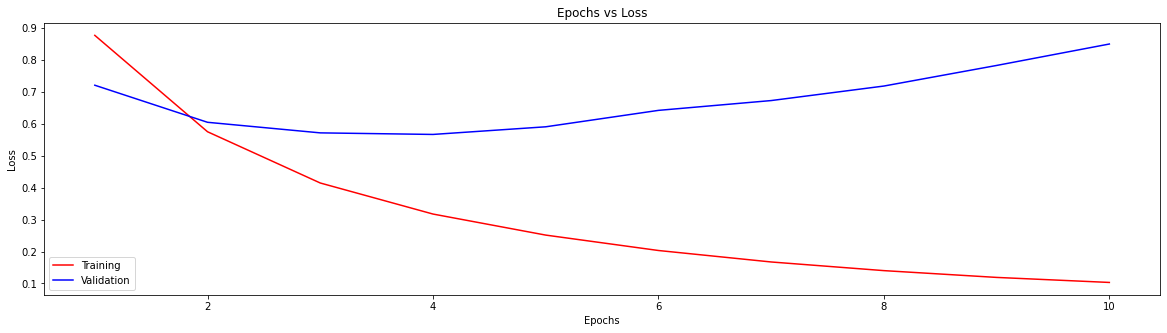

In [31]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_loss, "red")
plt.plot(test_epochs, test_loss, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.show()

### Accuracy graph

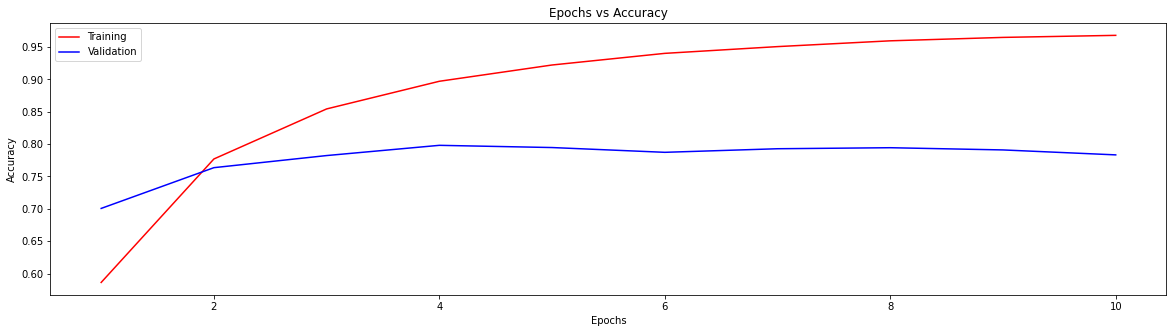

In [32]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_accuracy, "red")
plt.plot(test_epochs, test_accuracy, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

### F1 graph

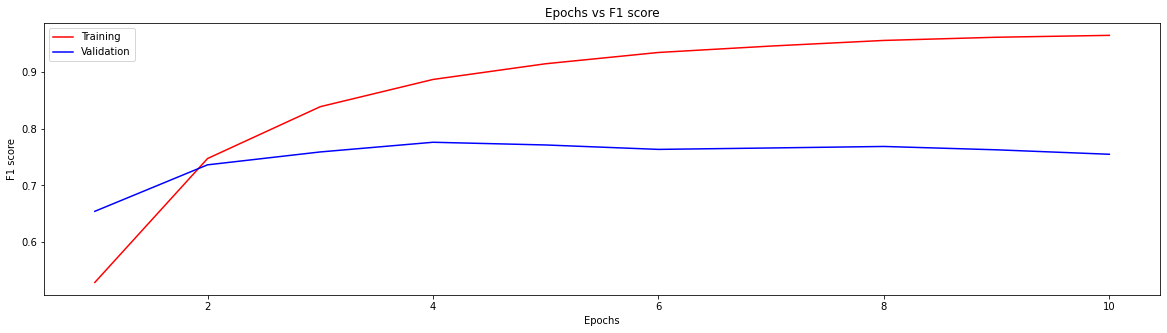

In [33]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_f1, "red")
plt.plot(test_epochs, test_f1, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.title("Epochs vs F1 score")
plt.show()

#### The model appears to overfit after four epochs
#### We can use the model from 4th epoch as final model since validation loss increases after 4 epochs

# Testing using saved model

In [34]:
# Load the saved weights
classifier_lstm.load_state_dict(torch.load("./classifier_lstm_4.pt"))

<All keys matched successfully>

# Testing on Training data

In [35]:
classifier_lstm.eval()
with torch.no_grad():

    true_values = []
    pred_values = []

    # Initialize progress bar
    pbar = tqdm(zip(encoded_train_X, train_y), total=len(train_y))
    for data, label in pbar:

    # Ignore empty sequences
        if len(data) == 0:
            continue

        out = classifier_lstm(data)

        # Store the true and predicted labels
        true_values.append(label.item())
        pred_values.append(torch.argmax(out[0,:]).item())

100%|██████████| 41157/41157 [00:20<00:00, 2017.04it/s]


In [36]:
# Classification report
print(classification_report(true_values, pred_values))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     18046
           1       0.92      0.95      0.93     15398
           2       0.93      0.86      0.89      7699

    accuracy                           0.93     41143
   macro avg       0.93      0.92      0.92     41143
weighted avg       0.93      0.93      0.93     41143



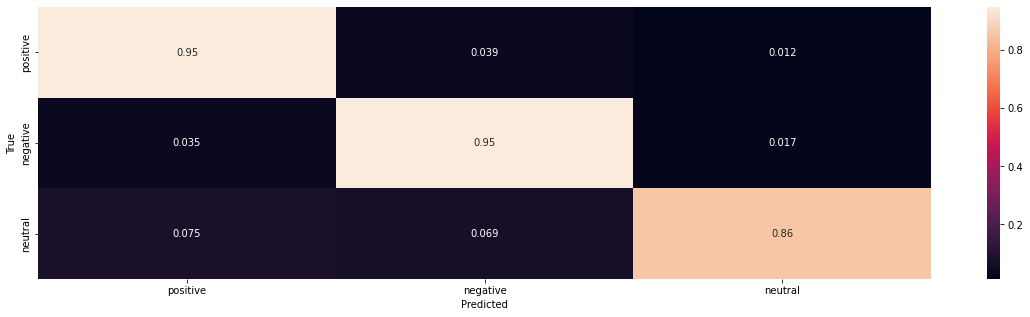

In [37]:
# Calculate confusion matrix
conf_mat = confusion_matrix(true_values, pred_values, normalize='true')

# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(conf_mat, annot=True)
labels = ["positive", "negative", "neutral"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Testing on test data

In [38]:
classifier_lstm.eval()
with torch.no_grad():

    true_values = []
    pred_values = []

    # Initialize progress bar
    pbar = tqdm(zip(encoded_test_X, test_y), total=len(test_y))
    for data, label in pbar:

    # Ignore empty sequences
        if len(data) == 0:
            continue

        out = classifier_lstm(data)

        # Store the true and predicted labels
        true_values.append(label.item())
        pred_values.append(torch.argmax(out[0,:]).item())

100%|██████████| 3798/3798 [00:01<00:00, 2111.57it/s]


In [39]:
# Classification report
print(classification_report(true_values, pred_values))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1546
           1       0.81      0.82      0.82      1633
           2       0.74      0.65      0.69       619

    accuracy                           0.80      3798
   macro avg       0.79      0.77      0.78      3798
weighted avg       0.80      0.80      0.80      3798



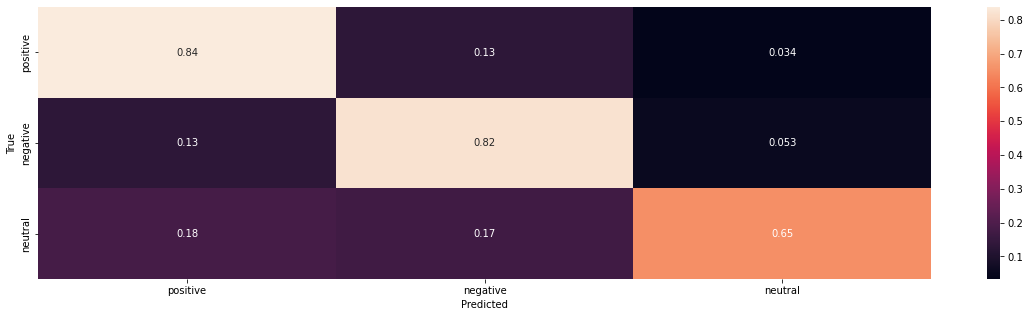

In [40]:
# Calculate confusion matrix
conf_mat = confusion_matrix(true_values, pred_values, normalize='true')

# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(conf_mat, annot=True)
labels = ["positive", "negative", "neutral"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# CONCLUSION

1. The accuracy of test data is lesser than the training data which denotes some bias towards training data
2. The performance of the model is better than the previous models based on TF-IDF and Hash vectors
3. The neutral samples are lesser than other classes hence its accuracy is lesser. To improve more neutral samples need to be added to the data
3. We can try the following techniques that may give better results <br>
   a. Other word embedding techniques like Word2Vec can be used. <br>
   b. Number of layers can be increased in the current model. <br>
   c. Transformer based models like BERT can be used - It will give better results but will require more data and time to train. 